# Klasifikasi Koin Indonesia - Cropped Features Only

Eksperimen menggunakan **HANYA cropped features** (35 features) untuk perbandingan dengan hybrid approach.

**Tujuan**: Melihat kontribusi cropped features tanpa original size information.

## 1. Import Libraries

In [ ]:
import sys
import os
from pathlib import Path

# Add parent directory to path (where preprocessing.py is located)
sys.path.insert(0, str(Path('..').resolve()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Setup Paths dan Konfigurasi

In [2]:
# Directories
BASE_DIR = Path('..').resolve()
DATASET_DIR = BASE_DIR / 'dataset'
RESULTS_DIR = BASE_DIR / 'results' / 'coin_classification2'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / 'confusion_matrix').mkdir(exist_ok=True)
(RESULTS_DIR / 'visualizations').mkdir(exist_ok=True)

# Configuration
IMAGE_SIZE = (512, 512)
MAX_IMAGES_PER_CLASS = 150
RANDOM_SEED = 42
TEST_SIZE = 0.2

np.random.seed(RANDOM_SEED)

print(f"Config: {IMAGE_SIZE}, max {MAX_IMAGES_PER_CLASS} imgs/class, test {TEST_SIZE*100}%")
print(f"Results will be saved to: {RESULTS_DIR}")

Config: (512, 512), max 150 imgs/class, test 20.0%
Results will be saved to: D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\coin_classification2


## 3. Fungsi Preprocessing Koin

In [3]:
def apply_canny_edge(image):
    """Apply Canny edge detection"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges


def apply_sobel_edge(image):
    """Apply Sobel edge detection"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(sobel_combined / sobel_combined.max() * 255)
    return sobel_combined


def detect_and_segment_coin(image, edge_method='canny'):
    """Detect coin using Hough Circle Transform and segment it"""
    if edge_method == 'canny':
        edges = apply_canny_edge(image)
    else:
        edges = apply_sobel_edge(image)
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=100,
        param2=30,
        minRadius=20,
        maxRadius=200
    )
    
    segmented = image.copy()
    circle_info = None
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circle = circles[0, 0]
        x, y, radius = circle[0], circle[1], circle[2]
        circle_info = (x, y, radius)
        
        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.circle(mask, (x, y), radius, 255, -1)
        
        if len(image.shape) == 3:
            segmented = cv2.bitwise_and(image, image, mask=mask)
        else:
            segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented, circle_info, edges

print("Preprocessing functions defined")

Preprocessing functions defined


## 4. Fungsi Crop dan Feature Extraction

In [4]:
from preprocessing import crop_coin_to_circle, extract_coin_features

print("Imported crop_coin_to_circle and extract_coin_features from preprocessing module")
print("These will be used to extract features from CROPPED version only (35 features)")

Imported crop_coin_to_circle and extract_coin_features from preprocessing module
These will be used to extract features from CROPPED version only (35 features)


## 5. Fungsi Data Augmentation

In [5]:
def augment_image(image):
    """Apply augmentation: rotation, flip, brightness (8x total)"""
    augmented = [image]
    
    for angle in [90, 180, 270]:
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented.append(rotated)
    
    flipped_h = cv2.flip(image, 1)
    flipped_v = cv2.flip(image, 0)
    augmented.extend([flipped_h, flipped_v])
    
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-20)
    augmented.extend([bright, dark])
    
    return augmented

print("Augmentation function defined (8x per image)")

Augmentation function defined (8x per image)


## 6. Load dan Eksplorasi Dataset

In [6]:
class_names = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
print(f"Classes: {class_names}")

for cls_name in class_names:
    cls_dir = DATASET_DIR / cls_name
    images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
    print(f"{cls_name}: {len(images)} images")

Classes: ['Koin Rp 100', 'Koin Rp 1000', 'Koin Rp 200', 'Koin Rp 500']
Koin Rp 100: 161 images
Koin Rp 1000: 219 images
Koin Rp 200: 173 images
Koin Rp 500: 211 images


## 7. Load dan Extract Features - CROPPED ONLY

**Key Difference**: Hanya menggunakan cropped version untuk feature extraction (35 features)

In [7]:
def load_and_extract_cropped_features(dataset_dir, class_names, edge_method='sobel', 
                                       apply_augmentation=False, max_images=None):
    """
    Load images and extract features from CROPPED version ONLY
    
    Returns 35 features per sample (from cropped & resized version only)
    
    Args:
        dataset_dir: Path to dataset directory
        class_names: List of class names
        edge_method: 'canny' or 'sobel'
        apply_augmentation: Whether to apply data augmentation
        max_images: Maximum images per class (None = no limit)
    
    Returns:
        X: Feature matrix (35 features from cropped version)
        y: Labels
    """
    X = []
    y = []
    
    for label, cls_name in enumerate(class_names):
        cls_dir = dataset_dir / cls_name
        images = list(cls_dir.glob('*.jpg')) + list(cls_dir.glob('*.png')) + list(cls_dir.glob('*.jpeg'))
        
        # Limit images per class if specified
        if max_images is not None and len(images) > max_images:
            np.random.shuffle(images)
            images = images[:max_images]
        
        print(f"Processing {cls_name}: {len(images)} images", end='')
        
        success_count = 0
        for img_path in images:
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            img_resized = cv2.resize(img, IMAGE_SIZE)
            
            # Apply augmentation if enabled
            if apply_augmentation:
                augmented_images = augment_image(img_resized)
            else:
                augmented_images = [img_resized]
            
            for aug_img in augmented_images:
                # 1. Detect coin and get circle info
                segmented_original, circle_info, _ = detect_and_segment_coin(aug_img, edge_method)
                
                if circle_info is not None:
                    # 2. Crop to circle diameter and resize
                    cropped = crop_coin_to_circle(segmented_original, circle_info, IMAGE_SIZE)
                    
                    # 3. Apply edge detection to cropped version
                    if edge_method == 'canny':
                        edges_cropped = apply_canny_edge(cropped)
                    else:
                        edges_cropped = apply_sobel_edge(cropped)
                    
                    # 4. Extract features from CROPPED version ONLY (35 features)
                    # Note: We pass None for circle_info since cropped image is normalized
                    features = extract_coin_features(cropped, edges_cropped, None)
                    
                    X.append(features)
                    y.append(label)
                    success_count += 1
        
        if apply_augmentation:
            print(f" -> {success_count} samples (cropped features, augmented)")
        else:
            print(f" -> {success_count} samples (cropped features)")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

print("Function defined: load_and_extract_cropped_features")
print("This extracts 35 features from CROPPED version only (no original size info)")

Function defined: load_and_extract_cropped_features
This extracts 35 features from CROPPED version only (no original size info)


### 7.1 Extract Cropped Features dengan Canny

In [8]:
print("="*70)
print("CANNY EDGE DETECTION - CROPPED FEATURES ONLY (35 features)")
print("="*70)

X_canny, y_canny = load_and_extract_cropped_features(
    DATASET_DIR,
    class_names,
    edge_method='canny',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS
)

print(f"\nTotal samples (Canny - Cropped): {len(X_canny)}")
print(f"Feature dimensions: {X_canny.shape[1]} features (cropped only)")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_canny, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

CANNY EDGE DETECTION - CROPPED FEATURES ONLY (35 features)
Processing Koin Rp 100: 150 images -> 1200 samples (cropped features, augmented)
Processing Koin Rp 1000: 150 images -> 1193 samples (cropped features, augmented)
Processing Koin Rp 200: 150 images -> 1200 samples (cropped features, augmented)
Processing Koin Rp 500: 150 images -> 1200 samples (cropped features, augmented)

Total samples (Canny - Cropped): 4793
Feature dimensions: 35 features (cropped only)
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1193 samples
  Koin Rp 200: 1200 samples
  Koin Rp 500: 1200 samples


### 7.2 Extract Cropped Features dengan Sobel

In [9]:
print("="*70)
print("SOBEL EDGE DETECTION - CROPPED FEATURES ONLY (35 features)")
print("="*70)

X_sobel, y_sobel = load_and_extract_cropped_features(
    DATASET_DIR,
    class_names,
    edge_method='sobel',
    apply_augmentation=True,
    max_images=MAX_IMAGES_PER_CLASS
)

print(f"\nTotal samples (Sobel - Cropped): {len(X_sobel)}")
print(f"Feature dimensions: {X_sobel.shape[1]} features (cropped only)")
print(f"Classes: {len(class_names)}")

# Check balance
unique, counts = np.unique(y_sobel, return_counts=True)
print("\nDistribusi data per kelas:")
for cls_idx, count in zip(unique, counts):
    print(f"  {class_names[cls_idx]}: {count} samples")

SOBEL EDGE DETECTION - CROPPED FEATURES ONLY (35 features)
Processing Koin Rp 100: 150 images -> 1200 samples (cropped features, augmented)
Processing Koin Rp 1000: 150 images -> 1194 samples (cropped features, augmented)
Processing Koin Rp 200: 150 images -> 1200 samples (cropped features, augmented)
Processing Koin Rp 500: 150 images -> 1200 samples (cropped features, augmented)

Total samples (Sobel - Cropped): 4794
Feature dimensions: 35 features (cropped only)
Classes: 4

Distribusi data per kelas:
  Koin Rp 100: 1200 samples
  Koin Rp 1000: 1194 samples
  Koin Rp 200: 1200 samples
  Koin Rp 500: 1200 samples


## 8. Split Data Training dan Testing

In [10]:
# Split data for Canny
X_train_canny, X_test_canny, y_train_canny, y_test_canny = train_test_split(
    X_canny, y_canny, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_canny
)

print("CANNY Edge Detection (Cropped Features):")
print(f"  Training set: {X_train_canny.shape[0]} samples")
print(f"  Testing set: {X_test_canny.shape[0]} samples")

# Split data for Sobel
X_train_sobel, X_test_sobel, y_train_sobel, y_test_sobel = train_test_split(
    X_sobel, y_sobel, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_sobel
)

print("\nSOBEL Edge Detection (Cropped Features):")
print(f"  Training set: {X_train_sobel.shape[0]} samples")
print(f"  Testing set: {X_test_sobel.shape[0]} samples")

CANNY Edge Detection (Cropped Features):
  Training set: 3834 samples
  Testing set: 959 samples

SOBEL Edge Detection (Cropped Features):
  Training set: 3835 samples
  Testing set: 959 samples


## 9. Model Training: Random Forest

### 9.1 Random Forest + Canny (Cropped)

In [11]:
print("Training Random Forest + Canny (Cropped Features)...")

scaler_rf_canny = StandardScaler()
X_train_canny_scaled = scaler_rf_canny.fit_transform(X_train_canny)
X_test_canny_scaled = scaler_rf_canny.transform(X_test_canny)

rf_canny = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_canny.fit(X_train_canny_scaled, y_train_canny)
y_pred_rf_canny = rf_canny.predict(X_test_canny_scaled)
acc_rf_canny = accuracy_score(y_test_canny, y_pred_rf_canny)

print(f"Accuracy: {acc_rf_canny:.4f}\n")
print(classification_report(y_test_canny, y_pred_rf_canny, target_names=class_names))

Training Random Forest + Canny (Cropped Features)...
Accuracy: 0.7716

              precision    recall  f1-score   support

 Koin Rp 100       0.72      0.82      0.77       240
Koin Rp 1000       0.80      0.73      0.76       239
 Koin Rp 200       0.82      0.75      0.79       240
 Koin Rp 500       0.76      0.78      0.77       240

    accuracy                           0.77       959
   macro avg       0.77      0.77      0.77       959
weighted avg       0.77      0.77      0.77       959



### 9.2 Random Forest + Sobel (Cropped)

In [12]:
print("Training Random Forest + Sobel (Cropped Features)...")

scaler_rf_sobel = StandardScaler()
X_train_sobel_scaled = scaler_rf_sobel.fit_transform(X_train_sobel)
X_test_sobel_scaled = scaler_rf_sobel.transform(X_test_sobel)

rf_sobel = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_sobel.fit(X_train_sobel_scaled, y_train_sobel)
y_pred_rf_sobel = rf_sobel.predict(X_test_sobel_scaled)
acc_rf_sobel = accuracy_score(y_test_sobel, y_pred_rf_sobel)

print(f"Accuracy: {acc_rf_sobel:.4f}\n")
print(classification_report(y_test_sobel, y_pred_rf_sobel, target_names=class_names))

Training Random Forest + Sobel (Cropped Features)...
Accuracy: 0.8081

              precision    recall  f1-score   support

 Koin Rp 100       0.75      0.86      0.80       240
Koin Rp 1000       0.81      0.74      0.77       239
 Koin Rp 200       0.82      0.85      0.83       240
 Koin Rp 500       0.87      0.78      0.82       240

    accuracy                           0.81       959
   macro avg       0.81      0.81      0.81       959
weighted avg       0.81      0.81      0.81       959



## 10. Model Training: SVM

### 10.1 SVM + Canny (Cropped)

In [13]:
print("Training SVM + Canny (Cropped Features)...")

svm_canny = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_SEED
)

svm_canny.fit(X_train_canny_scaled, y_train_canny)
y_pred_svm_canny = svm_canny.predict(X_test_canny_scaled)
acc_svm_canny = accuracy_score(y_test_canny, y_pred_svm_canny)

print(f"Accuracy: {acc_svm_canny:.4f}\n")
print(classification_report(y_test_canny, y_pred_svm_canny, target_names=class_names))

Training SVM + Canny (Cropped Features)...
Accuracy: 0.7383

              precision    recall  f1-score   support

 Koin Rp 100       0.65      0.79      0.71       240
Koin Rp 1000       0.79      0.67      0.73       239
 Koin Rp 200       0.81      0.80      0.81       240
 Koin Rp 500       0.74      0.69      0.71       240

    accuracy                           0.74       959
   macro avg       0.75      0.74      0.74       959
weighted avg       0.75      0.74      0.74       959



### 10.2 SVM + Sobel (Cropped)

In [14]:
print("Training SVM + Sobel (Cropped Features)...")

svm_sobel = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_SEED
)

svm_sobel.fit(X_train_sobel_scaled, y_train_sobel)
y_pred_svm_sobel = svm_sobel.predict(X_test_sobel_scaled)
acc_svm_sobel = accuracy_score(y_test_sobel, y_pred_svm_sobel)

print(f"Accuracy: {acc_svm_sobel:.4f}\n")
print(classification_report(y_test_sobel, y_pred_svm_sobel, target_names=class_names))

Training SVM + Sobel (Cropped Features)...
Accuracy: 0.7539

              precision    recall  f1-score   support

 Koin Rp 100       0.66      0.76      0.71       240
Koin Rp 1000       0.77      0.74      0.75       239
 Koin Rp 200       0.81      0.81      0.81       240
 Koin Rp 500       0.80      0.71      0.75       240

    accuracy                           0.75       959
   macro avg       0.76      0.75      0.75       959
weighted avg       0.76      0.75      0.75       959



## 11. Perbandingan Hasil Semua Model

In [15]:
comparison_df = pd.DataFrame({
    'Model': [
        'Random Forest + Canny',
        'Random Forest + Sobel',
        'SVM + Canny',
        'SVM + Sobel'
    ],
    'Edge Detection': ['Canny', 'Sobel', 'Canny', 'Sobel'],
    'Classifier': ['Random Forest', 'Random Forest', 'SVM', 'SVM'],
    'Features': ['35 (Cropped)', '35 (Cropped)', '35 (Cropped)', '35 (Cropped)'],
    'Accuracy': [acc_rf_canny, acc_rf_sobel, acc_svm_canny, acc_svm_sobel]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("MODEL COMPARISON (All using Cropped Features ONLY: 35 features)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)
print(f"\nBEST MODEL: {comparison_df.iloc[0]['Model']}")
print(f"  Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy']*100:.2f}%)")
print(f"  Features: {comparison_df.iloc[0]['Features']}")
print("="*80)

comparison_df.to_csv(RESULTS_DIR / 'model_comparison_cropped_only.csv', index=False)
print(f"\nSaved to: {RESULTS_DIR / 'model_comparison_cropped_only.csv'}")

MODEL COMPARISON (All using Cropped Features ONLY: 35 features)
                Model Edge Detection    Classifier     Features  Accuracy
Random Forest + Sobel          Sobel Random Forest 35 (Cropped)  0.808133
Random Forest + Canny          Canny Random Forest 35 (Cropped)  0.771637
          SVM + Sobel          Sobel           SVM 35 (Cropped)  0.753910
          SVM + Canny          Canny           SVM 35 (Cropped)  0.738269

BEST MODEL: Random Forest + Sobel
  Accuracy: 0.8081 (80.81%)
  Features: 35 (Cropped)

Saved to: D:\dev\semester5\pengolahan-citra\projek-edge-detection\results\coin_classification2\model_comparison_cropped_only.csv


### 11.1 Visualisasi Perbandingan Accuracy

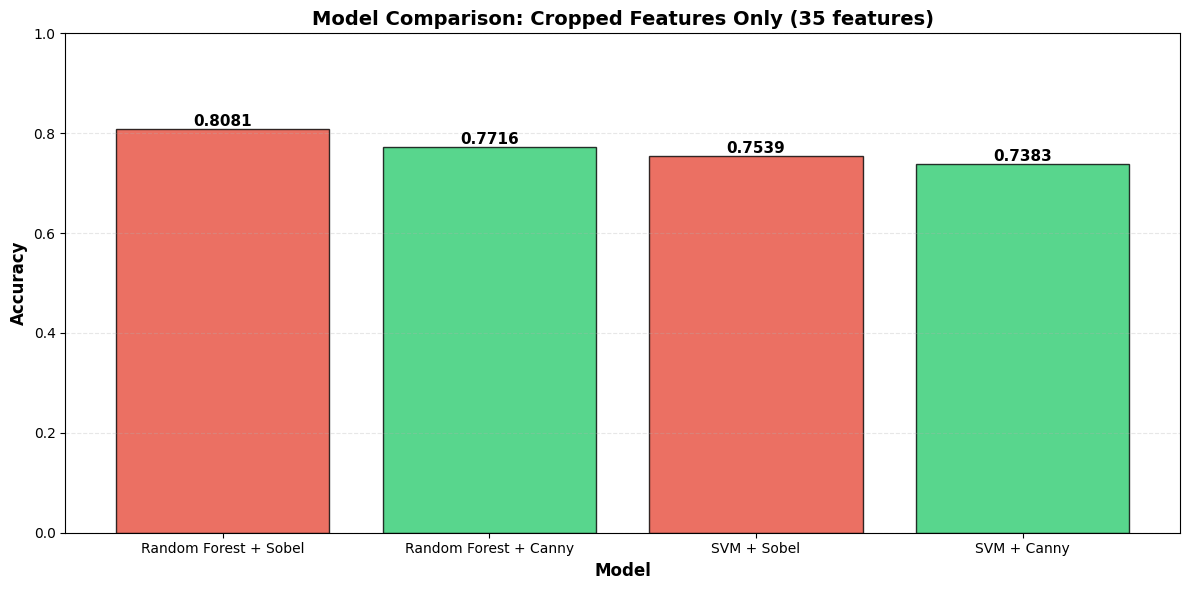

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2ecc71' if 'Canny' in model else '#e74c3c' for model in comparison_df['Model']]
bars = ax.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: Cropped Features Only (35 features)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

plt.savefig(RESULTS_DIR / 'visualizations' / 'accuracy_comparison_cropped.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Confusion Matrix untuk Model Terbaik

Model terbaik: Random Forest + Sobel
Accuracy: 0.8081



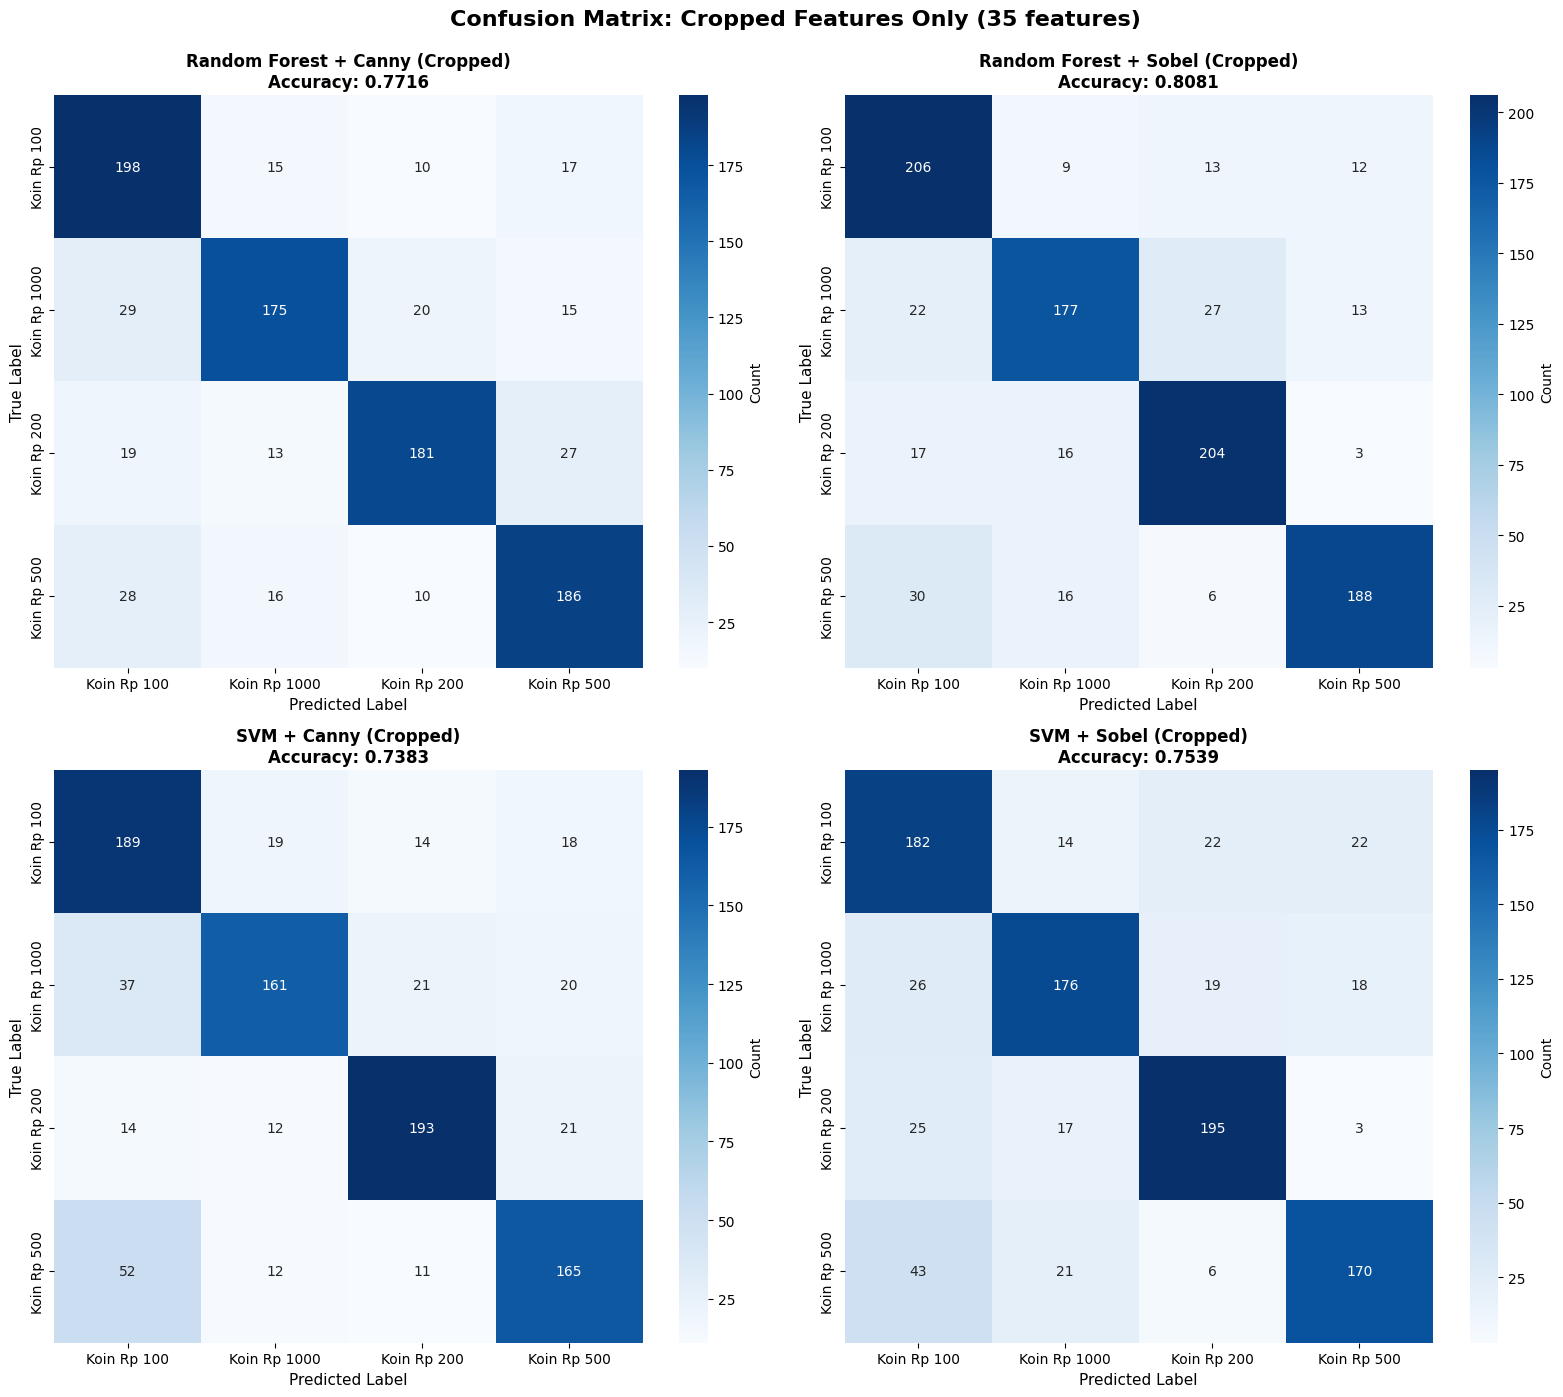

In [17]:
# Determine best model
best_model_row = comparison_df.iloc[0]
print(f"Model terbaik: {best_model_row['Model']}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}\n")

# Get predictions for all models
models_info = [
    ('Random Forest + Canny', y_test_canny, y_pred_rf_canny),
    ('Random Forest + Sobel', y_test_sobel, y_pred_rf_sobel),
    ('SVM + Canny', y_test_canny, y_pred_svm_canny),
    ('SVM + Sobel', y_test_sobel, y_pred_svm_sobel)
]

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, y_true, y_pred) in enumerate(models_info):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'{model_name} (Cropped)\nAccuracy: {accuracy_score(y_true, y_pred):.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    axes[idx].set_ylabel('True Label', fontsize=11)

plt.suptitle('Confusion Matrix: Cropped Features Only (35 features)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix' / 'all_models_confusion_matrix_cropped.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Kesimpulan

### Hasil Eksperimen: Cropped Features Only (35 features)

Notebook ini mengekstrak features **hanya dari cropped version** untuk melihat kontribusinya tanpa informasi ukuran absolut.

**Perbandingan dengan Hybrid Approach:**

| Approach | Features | Best Accuracy | Notes |
|----------|----------|---------------|-------|
| **Hybrid (Original + Cropped)** | 70 | ~88% | Combines size + texture info |
| **Cropped Only** | 35 | ? | Texture only, normalized scale |

**Expected Findings:**

- Cropped-only approach loses absolute size discrimination
- All coins normalized to same scale, focusing purely on texture/pattern
- Likely lower accuracy than hybrid due to missing size information
- But may show good texture-based discrimination capability

## 14. Save Best Model

In [18]:
import pickle

MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Determine best model from comparison
best_model_row = comparison_df.iloc[0]
print(f"Best Model: {best_model_row['Model']}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}\n")

# Save the best model (Random Forest + Sobel with Cropped features)
best_model_name = 'random_forest_cropped_only'

model_path = MODELS_DIR / f'{best_model_name}_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_sobel, f)

scaler_path = MODELS_DIR / f'{best_model_name}_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler_rf_sobel, f)

print(f"Model saved: {model_path.relative_to(BASE_DIR)}")
print(f"Scaler saved: {scaler_path.relative_to(BASE_DIR)}")
print(f"Accuracy: {acc_rf_sobel:.4f}")
print(f"Features: 35 (cropped only)")

Best Model: Random Forest + Sobel
Accuracy: 0.8081

Model saved: models\random_forest_cropped_only_model.pkl
Scaler saved: models\random_forest_cropped_only_scaler.pkl
Accuracy: 0.8081
Features: 35 (cropped only)
